# Geração Paralela do Conjunto de Mandelbrot em Python
### Versão sequencial, paralela em CPU (`multiprocessing`) e (opcional) GPU com Numba‐CUDA


## 1. Introdução  
O conjunto de Mandelbrot é um exemplo clássico de **fractal** cujo ponto forte para paralelização é a independência de cálculo de cada pixel.  
Objetivos deste notebook:

1. Implementar a versão **sequencial** do algoritmo.  
2. Implementar a versão **paralela em CPU** usando **memória compartilhada** (`multiprocessing`).  
3. (Opcional) Implementar a versão **GPU** via **Numba‐CUDA**.  
4. Medir desempenho, calcular *speedup*, *eficiência* e gerar gráficos comparativos.  


In [6]:
!pip install numpy matplotlib pandas
!pip install numba
!pip install pycuda



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pycuda-2025.1.1.tar.gz (1.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pytools-2025.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached siphash24-1.7.tar.gz (19 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + meson setup C:\Users\Pedro Paulo\AppData\Local\Temp\pip-install-euokofwu\siphash24_2b7c741dcd36401ba2396473a7d8bd0c C:\Users\Pedro Paulo\AppData\Local\Temp\pip-install-euokofwu\siphash24_2b7c741dcd36401ba2396473a7d8bd0c\.mesonpy-cs4woxmu -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\Pedro Paulo\AppData\Local\Temp\pip-install-euokofwu\siphash24_2b7c741dcd36401ba2396473a7d8bd0c\.mesonpy-cs4woxmu\meson-python-native-file.ini
      The Meson build system
      Version: 1.8.2
      Source dir: C:\Users\Pedro Paulo\AppData\Local\Temp\pip-install-euokofwu\siphash24_2b7c741dcd36401ba2396473a7d8bd0c
      Build dir: C:\Users\Pedro Paulo\AppData\Local\Temp\pip-install-euokofwu\siphash24_2b7c741dcd36401ba2396473a7d8bd0c\.mesonpy-cs4woxmu
      Build type: native build
      Project name: python-siphash24
    

In [1]:
!pip install joblib tqdm



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

# ----------------------- Parâmetros padrão -----------------------
WIDTH, HEIGHT = 3840 , 2160        # Resolução 4K
MAX_ITER       = 1000             # Iterações por pixel
RE_START, RE_END = -2.0, 1.0      # Faixa do eixo real
IM_START, IM_END = -1.5, 1.5      # Faixa do eixo imaginário


In [10]:
def show_mandelbrot(img, title="Mandelbrot"):
    """Mostra a matriz gerada como imagem RGB."""
    plt.figure(figsize=(8, 4.5))
    plt.imshow(img, extent=[RE_START, RE_END, IM_START, IM_END])
    plt.title(title)
    plt.axis('off')
    plt.show()


Tempo sequencial: 27.16 s


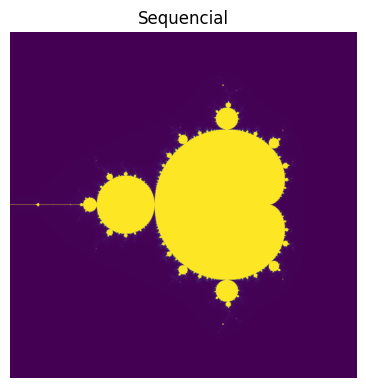

In [12]:
def mandelbrot_seq(width, height, max_iter):
    """Gera matriz (height, width) com valor de iteração para cada pixel."""
    img = np.zeros((height, width), dtype=np.uint16)
    for y in range(height):
        imag = IM_START + (y / height) * (IM_END - IM_START)
        for x in range(width):
            real = RE_START + (x / width) * (RE_END - RE_START)
            c = complex(real, imag)
            z = 0j
            iter_count = 0
            while abs(z) <= 2 and iter_count < max_iter:
                z = z*z + c
                iter_count += 1
            img[y, x] = iter_count
    return img

# ----------- Benchmark sequencial -----------
t0 = perf_counter()
seq_img = mandelbrot_seq(WIDTH, HEIGHT, MAX_ITER)
t_seq = perf_counter() - t0
print(f"Tempo sequencial: {t_seq:.2f} s")

show_mandelbrot(seq_img, "Sequencial")


100%|██████████| 2160/2160 [00:15<00:00, 136.60it/s]


16 thread(s): 16.11 s


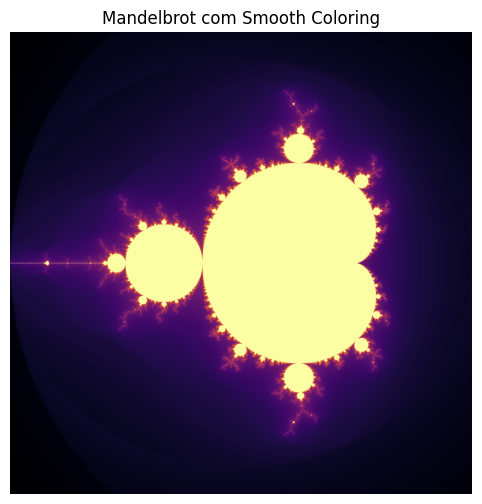

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt

def compute_line_smooth(y):
    """Calcula a linha y do fractal com smooth coloring"""
    line = np.zeros(WIDTH, dtype=np.float32)
    imag = IM_START + (y / HEIGHT) * (IM_END - IM_START)
    for x in range(WIDTH):
        real = RE_START + (x / WIDTH) * (RE_END - RE_START)
        c = complex(real, imag)
        z = 0j
        iter_count = 0
        while abs(z) <= 2 and iter_count < MAX_ITER:
            z = z*z + c
            iter_count += 1
        if iter_count < MAX_ITER:
            # Aplicando smooth coloring
            log_zn = np.log(z.real*z.real + z.imag*z.imag) / 2
            nu = np.log(log_zn / np.log(2)) / np.log(2)
            line[x] = iter_count + 1 - nu
        else:
            line[x] = iter_count  # dentro do conjunto (preto)
    return line

def mandelbrot_joblib_smooth(n_jobs):
    """Gera imagem com smooth coloring usando joblib"""
    result = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(compute_line_smooth)(y) for y in tqdm(range(HEIGHT))
    )
    return np.array(result, dtype=np.float32)




# ----------- Benchmark com smooth coloring -----------

results_cpu = []

for n_jobs in [16]:
    t0 = perf_counter()
    img_smooth = mandelbrot_joblib_smooth(n_jobs)
    dt = perf_counter() - t0
    results_cpu.append((n_jobs, dt))
    print(f"{n_jobs} thread(s): {dt:.2f} s")

# Aplicando compressão logarítmica para melhor contraste visual
log_img = np.log(img_smooth + 1)  # evita log(0)
img_norm = log_img / log_img.max()


# Exibir com colormap suave
plt.figure(figsize=(8, 6))
plt.imshow(img_norm, cmap="inferno", extent=[RE_START, RE_END, IM_START, IM_END])
plt.axis("off")
plt.title("Mandelbrot com Smooth Coloring")
plt.show()

# Salvar imagem final em alta resolução
plt.imsave("mandelbrot_smooth_4k.png", img_norm, cmap="plasma")



In [3]:
# Descomente se tiver GPU + numba disponível
from numba import cuda

@cuda.jit
def mandelbrot_gpu(img, re_start, re_end, im_start, im_end, max_iter):
    y, x = cuda.grid(2)
    height, width = img.shape
    if y < height and x < width:
        real = re_start + x / width  * (re_end - re_start)
        imag = im_start + y / height * (im_end - im_start)
        c = complex(real, imag)
        z = 0j
        iter_count = 0
        while (z.real*z.real + z.imag*z.imag) <= 4 and iter_count < max_iter:
            z = z*z + c
            iter_count += 1
        img[y, x] = iter_count

def mandelbrot_cuda(width, height, max_iter):
    """Wrapper para lançar kernel CUDA (precisa de GPU)."""
    img_device = cuda.device_array((height, width), np.uint16)
    threadsperblock = (16, 16)
    blockspergrid_x = (width  + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid_y = (height + threadsperblock[0] - 1) // threadsperblock[0]
    mandelbrot_gpu[(blockspergrid_y, blockspergrid_x),
                   threadsperblock](img_device, RE_START, RE_END,
                                    IM_START, IM_END, max_iter)
    return img_device.copy_to_host()

# # ----------- Benchmark GPU -----------
t0 = perf_counter()
img_gpu = mandelbrot_cuda(WIDTH, HEIGHT, MAX_ITER)
t_gpu = perf_counter() - t0
print(f"Tempo GPU: {t_gpu:.2f} s")
show_mandelbrot(img_gpu, "GPU")


NvvmSupportError: libNVVM cannot be found. Do `conda install cudatoolkit`:
Could not find module 'nvvm.dll' (or one of its dependencies). Try using the full path with constructor syntax.